In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sbermarket/sample_submission.csv
/kaggle/input/sbermarket/train-2.csv


In [51]:
train_df = pd.read_csv("/kaggle/input/sbermarket/train-2.csv")
sub_df = pd.read_csv("/kaggle/input/sbermarket/sample_submission.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   user_id             int64 
 1   order_completed_at  object
 2   cart                int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB


In [8]:
train_df.head(20)

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
5,2,2015-03-22 09:25:46,82
6,2,2015-03-22 09:25:46,134
7,2,2015-03-22 09:25:46,16
8,2,2015-03-22 09:25:46,409
9,2,2015-03-22 09:25:46,384


In [59]:
carts_count = train_df.cart.nunique()
users_count = train_df.user_id.nunique()

20000

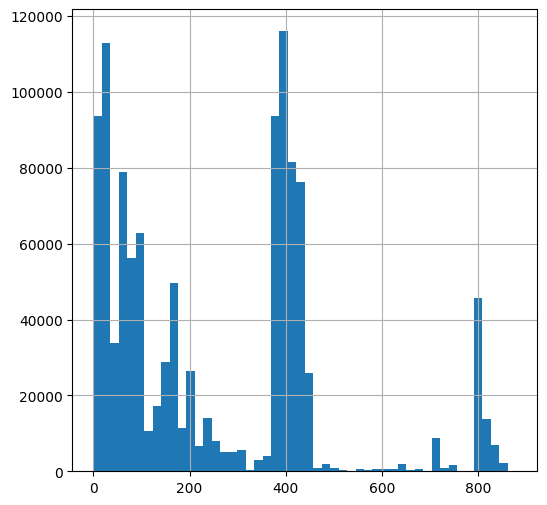

In [25]:
train_with_cnt = train_df.groupby(['user_id'])['cart'].value_counts().reset_index(name='count')
train_with_cnt['cart'].hist(bins=50, figsize=(6, 6))
plt.show()

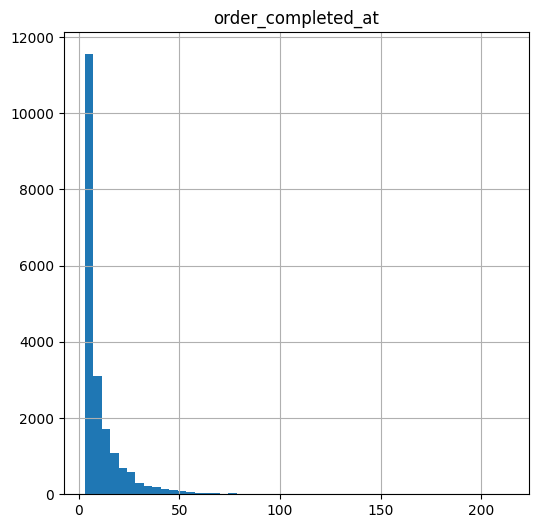

In [23]:
train_with_ord = train_df.groupby(['user_id'])['order_completed_at'].nunique().to_frame()
train_with_ord.hist(bins=50, figsize=(6, 6))
plt.show()

# Формирование выборок

In [15]:
train = train_df.groupby(["user_id", "order_completed_at"])["cart"].value_counts().to_frame().reset_index()                                                
train

,user_id,order_completed_at,cart,count
0,0,2020-07-19 09:59:17,14,1
1,0,2020-07-19 09:59:17,20,1
2,0,2020-07-19 09:59:17,57,1
3,0,2020-07-19 09:59:17,82,1
4,0,2020-07-19 09:59:17,379,1
...,...,...,...,...
3123059,19998,2020-09-02 15:03:23,409,1
3123060,19998,2020-09-02 15:03:23,798,1
3123061,19999,2020-08-31 18:54:24,326,1
3123062,19999,2020-08-31 19:32:08,326,1


In [16]:
train["order_completed_at"] = pd.to_datetime(train["order_completed_at"], format="%Y-%m-%d %H:%M:%S")

In [17]:
train.sort_values("order_completed_at", ascending=False)

,user_id,order_completed_at,cart,count
2529964,12702,2020-09-03 23:45:45,409,1
2529946,12702,2020-09-03 23:45:45,17,1
2529948,12702,2020-09-03 23:45:45,22,1
2529960,12702,2020-09-03 23:45:45,380,1
2529950,12702,2020-09-03 23:45:45,24,1
...,...,...,...,...
94,2,2015-03-22 09:25:46,409,1
81,2,2015-03-22 09:25:46,14,1
92,2,2015-03-22 09:25:46,384,1
91,2,2015-03-22 09:25:46,198,1


In [18]:
# таргетом для тренировочной выборки будут последние купленные товары
last_time_buy = train.groupby(["user_id"])["order_completed_at"].max().to_frame().reset_index()
last_time_buy["last_buy"] = 1

train_with_ltb = pd.merge(train, last_time_buy, on=["order_completed_at", "user_id"], how="left")
train_with_ltb.last_buy = train_with_ltb.last_buy.fillna(0)
train_with_ltb

,user_id,order_completed_at,cart,count,last_buy
0,0,2020-07-19 09:59:17,14,1,0.0
1,0,2020-07-19 09:59:17,20,1,0.0
2,0,2020-07-19 09:59:17,57,1,0.0
3,0,2020-07-19 09:59:17,82,1,0.0
4,0,2020-07-19 09:59:17,379,1,0.0
...,...,...,...,...,...
3123059,19998,2020-09-02 15:03:23,409,1,1.0
3123060,19998,2020-09-02 15:03:23,798,1,1.0
3123061,19999,2020-08-31 18:54:24,326,1,0.0
3123062,19999,2020-08-31 19:32:08,326,1,0.0


In [ ]:
# создаем таблицу для обучения модели без последних купленных товаров
new_train = train_with_ltb[train_with_ltb["last_buy"] != 1]
new_train.drop(columns=["last_buy"], inplace=True)

In [20]:
def make_cart_df(t):
    """Функция для создание таблицы с уникальными корзинами дляя каждого покупателя"""
    return t.groupby("user_id")["cart"].unique().to_frame().reset_index().explode("cart")

# создаем таблицу последних корзинок покупателей
last_time_buy.drop(columns=["last_buy"], inplace=True)
last_carts = pd.merge(last_time_buy, train, on=["user_id", "order_completed_at"], how="left")

cart_df = make_cart_df(train)

# таргеты - товары присутствующие в последней корзине покупателя
targets = pd.merge(cart_df, last_carts.drop(columns=["order_completed_at"]), on=["user_id","cart"], how="left")
targets.fillna(0, inplace=True)
targets.rename(columns={"count":"target"}, inplace=True)
targets

,user_id,cart,target
0,0,14,0.0
1,0,20,0.0
2,0,57,1.0
3,0,82,0.0
4,0,379,0.0
...,...,...,...
1117595,19998,84,1.0
1117596,19998,19,1.0
1117597,19998,409,1.0
1117598,19998,798,1.0


# Создание модели
В качестве алгоритма обучения используется TIFU KNN

In [22]:
# "вытягивание" тренировочного датасета для применения алгоритма
main_train = pd.pivot_table(new_train, columns="cart", index=["user_id", "order_completed_at"], values="count", aggfunc=np.sum, fill_value=0)
for cart in list(set(train["cart"].unique()).difference(set(new_train["cart"].unique()))):
    main_train[cart] = 0
main_train

/tmp/ipykernel_33/868875762.py:1: FutureWarning: The provided callable <function sum at 0x7cc61c2235b0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  main_train = pd.pivot_table(new_train, columns="cart", index=["user_id", "order_completed_at"], values="count", aggfunc=np.sum, fill_value=0)


cart                         0    1    2    3    4    5    6    7    8    9    \
user_id order_completed_at                                                      
0       2020-07-19 09:59:17    0    0    0    0    0    0    0    0    0    0   
        2020-08-24 08:55:32    0    0    0    0    0    1    0    0    0    0   
1       2019-05-08 16:09:41    0    0    0    0    0    0    0    0    0    0   
        2020-01-17 14:44:23    0    0    0    0    0    0    0    0    0    0   
        2020-02-06 22:46:55    0    0    0    0    0    0    0    0    0    0   
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19997   2020-08-31 11:04:05    1    0    0    0    0    0    0    0    0    0   
19998   2020-08-30 12:15:55    0    0    0    0    0    0    1    0    0    0   
        2020-09-01 08:12:32    0    0    0    0    0    0    1    0    0    0   
19999   2020-08-31 18:54:24    0    0    0    0    0    0    0    0    0    0   
        2020-08-31 19:32:08    0    0    0    0    0    0    0    0    0    0   

cart                         ...  872  777  841  752  594  789  726  472  795  \
user_id order_completed_at   ...                                                
0       2020-07-19 09:59:17  ...    0    0    0    0    0    0    0    0    0   
        2020-08-24 08:55:32  ...    0    0    0    0    0    0    0    0    0   
1       2019-05-08 16:09:41  ...    0    0    0    0    0    0    0    0    0   
        2020-01-17 14:44:23  ...    0    0    0    0    0    0    0    0    0   
        2020-02-06 22:46:55  ...    0    0    0    0    0    0    0    0    0   
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19997   2020-08-31 11:04:05  ...    0    0    0    0    0    0    0    0    0   
19998   2020-08-30 12:15:55  ...    0    0    0    0    0    0    0    0    0   
        2020-09-01 08:12:32  ...    0    0    0    0    0    0    0    0    0   
19999   2020-08-31 18:54:24  ...    0    0    0    0    0    0    0    0    0   
        2020-08-31 19:32:08  ...    0    0    0    0    0    0    0    0    0   

cart                         510  
user_id order_completed_at        
0       2020-07-19 09:59:17    0  
        2020-08-24 08:55:32    0  
1       2019-05-08 16:09:41    0  
        2020-01-17 14:44:23    0  
        2020-02-06 22:46:55    0  
...                          ...  
19997   2020-08-31 11:04:05    0  
19998   2020-08-30 12:15:55    0  
        2020-09-01 08:12:32    0  
19999   2020-08-31 18:54:24    0  
        2020-08-31 19:32:08    0  

[189406 rows x 881 columns]

In [23]:
# сортировка строк по времени заказа
main_train = main_train.reindex(sorted(main_train.columns), axis=1).reset_index()
main_train.sort_values("order_completed_at", ascending=False, inplace=True)

In [24]:
main_train.head()

cart,user_id,order_completed_at,0,1,2,3,4,5,6,7,...,871,872,873,874,875,876,877,878,879,880
134963,10497,2020-09-03 20:03:55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187074,19237,2020-09-03 19:42:35,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139882,11107,2020-09-03 15:19:32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159623,13763,2020-09-03 14:35:33,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161461,14041,2020-09-03 13:43:03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# создание набора корзин для каждого пользователя
all_carts = [[] for i in range(users_count)]
main_array = main_train.to_numpy()
for arr in tqdm(main_array):
    all_carts[arr[0]].append(arr[2:])

100%|██████████| 189406/189406 [00:00<00:00, 584621.48it/s]


In [27]:

def get_users_one_cart(users, r):
    """
    Функция для создания вектора корзин покупателя с учетом веса корзины. 
    
    users: все корзины пользователя
    r: весовой коэффициент
    """
    users_cart = [[] for i in range(users_count)]
    for i in tqdm(range(len(users))):
        cart = pd.Series(np.zeros(carts_count), dtype=float)
        for j in range(len(users[i])):
            cart += pd.Series(users[i][j]) * r**(j)
        users_cart[i] = cart.tolist()
    return users_cart

In [31]:
user_vector = get_users_one_cart(all_carts, 0.75)

100%|██████████| 20000/20000 [02:11<00:00, 151.74it/s]


In [32]:
def get_neighbors_nn(carts, n): 
    """
    Функция для поиска похожих покупателей.
    
    carts: вектор (корзин) пользователей
    n:  количество соседей
    """
    model = NearestNeighbors()
    model.fit(carts)
    neighbors = model.kneighbors(carts, n_neighbors=n+1, return_distance=False)
    return neighbors

In [33]:
neighbors = get_neighbors_nn(user_vector, 10)

In [34]:
# Итоговый вектор пользователя высчитывается по формуле P = v_user * alpha + v_avg_neighbors * (1 - alpha)
def neighbors_avg(carts, neighbors, alpha):
    """
    Функция для нахождения итогового вектора весов. 
    Формула для вычисления: P = user * alpha + neighbors * (1-alpha)
    
    carts: вектор корзин покупателя
    neighbors: похожие покупатели
    alpha: весовой коэффициент 
    """
    avg_nbrs = [ [] for i in range(users_count)]
    for i in tqdm(range(users_count)):
        avg = pd.Series(np.zeros(carts_count))
        cur_weights = 0
        for j in range(1, len(neighbors[i])):
            avg += pd.Series(carts[neighbors[i][j]]) * (len(neighbors[i]) - j)
            cur_weights += (len(neighbors[i]) - j)
        avg /= (cur_weights if cur_weights != 0 else 1)
        avg_nbrs[i] = avg
    return [pd.Series(carts[i]) * alpha + pd.Series(avg_nbrs[i]) * (1-alpha) for i in range(users_count)]

In [35]:
final_vectors = neighbors_avg(user_vector, neighbors, 0.95)

100%|██████████| 20000/20000 [01:41<00:00, 197.27it/s]


In [38]:
# находим топ 15 позиций с максимальными значениями - популярными товарами
top_k = 15
best_basket = []
for i in tqdm(range(users_count)):
    best_basket.append(final_vectors[i].sort_values(ascending=False).head(top_k).index.tolist())


100%|██████████| 20000/20000 [00:03<00:00, 5086.28it/s]


In [39]:
best_basket[:5]

[[14, 57, 82, 379, 441, 405, 84, 5, 22, 383, 382, 409, 396, 432, 402],
 [55, 798, 169, 14, 170, 171, 812, 88, 23, 231, 19, 86, 82, 204, 421],
 [61, 23, 403, 57, 87, 382, 15, 82, 383, 412, 160, 100, 396, 393, 430],
 [57, 61, 84, 382, 430, 383, 398, 15, 41, 19, 43, 16, 399, 42, 77],
 [57, 420, 398, 84, 22, 712, 388, 61, 100, 16, 98, 102, 54, 29, 17]]

# Тестирование

In [41]:
recs = pd.DataFrame()
recs["user_id"] = [i for i in range(users_count)]
recs["cart"] = best_basket

In [42]:
recs.head()

,user_id,cart
0,0,"[14, 57, 82, 379, 441, 405, 84, 5, 22, 383, 38..."
1,1,"[55, 798, 169, 14, 170, 171, 812, 88, 23, 231,..."
2,2,"[61, 23, 403, 57, 87, 382, 15, 82, 383, 412, 1..."
3,3,"[57, 61, 84, 382, 430, 383, 398, 15, 41, 19, 4..."
4,4,"[57, 420, 398, 84, 22, 712, 388, 61, 100, 16, ..."


In [43]:
recs = recs.explode('cart')
recs['predict'] = 1
recs.head()

,user_id,cart,predict
0,0,14,1
0,0,57,1
0,0,82,1
0,0,379,1
0,0,441,1


In [71]:
res = pd.merge(targets, recs, on=["user_id", 'cart'], how="left")
res['predict'] = res['predict'].fillna(0).astype(int)
res.head()

,user_id,cart,target,predict
0,0,14,0.0,1
1,0,20,0.0,0
2,0,57,1.0,1
3,0,82,0.0,1
4,0,379,0.0,1


In [103]:
from sklearn.metrics import f1_score

In [104]:
round(f1_score(res["target"], res["predict"]), 5)

0.37217

# Для submission

In [ ]:
def split_id(s):
    return s.split(';')[0]

def split_cart(s):
    return s.split(';')[1]

In [61]:
sub = pd.DataFrame()
sub["id"] = sub_df["id"]
sub["user_id"] = sub_df["id"].apply(split_id).astype("int")
sub["cart"] = sub_df["id"].apply(split_cart).astype("int")
sub.drop(columns=["target"], inplace=True)
sub

,id,user_id,cart
0,0;133,0,133
1,0;5,0,5
2,0;10,0,10
3,0;396,0,396
4,0;14,0,14
...,...,...,...
790444,19998;26,19998,26
790445,19998;31,19998,31
790446,19998;29,19998,29
790447,19998;798,19998,798


In [74]:
res_sub = pd.merge(sub, recs, on=["user_id", "cart"], how="left")
res_sub["predict"] = res_sub["predict"].fillna(0).astype(int)
res_sub.rename(columns={"predict":"target"}, inplace=True)

In [75]:
res_sub.head()

,id,user_id,cart,target
0,0;133,0,133,0
1,0;5,0,5,1
2,0;10,0,10,0
3,0;396,0,396,1
4,0;14,0,14,1


In [76]:
res_sub.drop(columns=["user_id", "cart"], inplace=True)
res_sub

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,1
...,...,...
790444,19998;26,1
790445,19998;31,1
790446,19998;29,1
790447,19998;798,0


In [77]:
res_sub.to_csv("predict.csv", index=False)